In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [4]:
import os
from google_images_download import google_images_download
import datetime
import threading
import sys
import cv2

from fastai.vision import *
from fastai.metrics import error_rate

Completed Image ====> 83.aFlowercrops.jpg
Completed Image ====> 84.Columbus.jpg
Completed Image ====> 53.CEM47297892_128101839785.jpg


In [6]:
def newDownload(DATASET_DOWNLOAD_KEYWORDS, top_layer=True):
    os.makedirs(FOLDER, exist_ok=True)
#     try:
#         downloaded = open("downloaded.txt", "r")
#         downloaded_list = downloaded.readlines()
#         downloaded.close()
#     except:
#         downloaded_list = []

#     for i in range(len(downloaded_list)):
#         downloaded_list[i] = downloaded_list[i][0:-1]
#     downloaded_list = set(downloaded_list)
#     # print(downloaded_list)
#     downloaded_list = downloaded_list.intersection(DATASET_DOWNLOAD_KEYWORDS)
#     validFiles = []
#     for filename in os.listdir(FOLDER):
#         # print(filename[0:-6])
#         if filename[0:-7] in downloaded_list:
#             validFiles.append(filename)
#     toDelete = set(os.listdir(FOLDER)) - set(validFiles)
#     # print(toDelete)
#     for filename in toDelete:
#         os.remove(FOLDER + filename)
#     dataset_keywords = list(set(DATASET_DOWNLOAD_KEYWORDS) - downloaded_list)

    dataset_keywords = DATASET_DOWNLOAD_KEYWORDS
    response = google_images_download.googleimagesdownload()
    to_download = int(DATASET_NUM_IMAGES * 2) - len(os.listdir(FOLDER))
    num_per_key = int(to_download / max(1, len(dataset_keywords)) / DATASET_DOWNLOAD_TIME_MUL)
    num_extra_img = to_download - num_per_key * len(dataset_keywords)
    if not os.path.isfile("downloaded.txt"):
        downloaded = open("downloaded.txt", "w+")
        downloaded.close()

    for j, i in enumerate(dataset_keywords):
        for time_shift in range(DATASET_DOWNLOAD_TIME_MUL):
            try:
                start_date = (datetime.date.today() -
                              datetime.timedelta(days=3650/DATASET_DOWNLOAD_TIME_MUL *
                                                      (time_shift + 1))).strftime("%d/%m/%Y")
                end_date = (datetime.date.today() -
                            datetime.timedelta(days=3650/DATASET_DOWNLOAD_TIME_MUL *
                                                    time_shift)).strftime("%d/%m/%Y")
                response.download({"keywords": i, "limit": min(num_per_key + (1 if j < num_extra_img else 0), 100),
                                   "exact_size": "640,480", "image_directory": ".",
                                   "time_range":'{"time_min":"'+start_date+'","time_max":"'+end_date+'"}'})
            except Exception as e:
                print(e)
            else:
                if min(num_per_key + (1 if j < num_extra_img else 0), 100) == 100:
                    print("keyword finished")
#     if top_layer:
#         newDownload(top_layer=False)


def downloadsFilter():
    for filename in os.listdir(FOLDER):
        if filename.endswith('.jpg'):
            try:
                src = cv2.imread(FOLDER + filename, cv2.IMREAD_COLOR)
                rows, cols, colors = src.shape
                if rows != 480 or cols != 640 or colors != 3:
                    raise ValueError("lol its d rong sheip")
            except Exception as e:
                print(e)
                os.remove(FOLDER + filename)
        else:
            os.remove(FOLDER + filename)
            

keywords = {"wildfire": ["wildfire", "forest fire", "bushfire", "lesni pozar", "wildfire town", "california wildfire", "amazon wildfire photo"],
            "not": ["urban area", "forest", "savannah", "campfire", "burning house", "photo", "office"]}
for cls in ["wildfire", "not"]:
    DATASET_DOWNLOAD_KEYWORDS = keywords[cls]
    DATASET_DOWNLOAD_TIME_MUL = 5
    DATASET_NUM_IMAGES = 10000
    FOLDER = "downloads/" + cls + "/"
    
    num_threads = len(DATASET_DOWNLOAD_KEYWORDS)
    threads = [None for i in range(num_threads)]
    for i in range(num_threads):
        threads[i] = threading.Thread(target=newDownload,
                                      args=([DATASET_DOWNLOAD_KEYWORDS[i]],))
        threads[i].start()

    for i in range(num_threads):
        threads[i].join()
    index = 0
    for filename in os.listdir("downloads/"):
        if not os.path.isfile("downloads/" + filename):
            continue
        try:
            if filename[0].isdigit():
                os.rename("downloads/" + filename, FOLDER + str(index).zfill(3) + ".jpg")
                index += 1
        except Exception as e:
            print(e)
    
    downloadsFilter()

Completed Image ====> 18.EAM7HWGL3Y36RNRL6JJUWLS2GQ.jpg
Completed Image ====> 66._%D0%BF%D0%B0%D0%B7%D0%BE%D0%B2_2.JPG
Completed Image ====> 87.baltimore-amazon-warehouse-collapse-2018-11-2.jpg
Completed Image ====> 19.wildfire-fire-featured.jpg
Completed Image ====> 60.sedona_fire_t715.jpg
Completed Image ====> 67.brick.jpg
Completed Image ====> 88.vt-copy-164.jpg
Invalid or missing image format. Skipping...
Invalid or missing image format. Skipping...
Completed Image ====> 89.sddefault.jpg
Completed Image ====> 68.cc0e7c98-8d8e-4a22-bc62-b9e2feeff1ec.jpg
Completed Image ====> 61.nahanni-butte-forest-fire.JPG

Item no.: 1 --> Item name = bushfire
Evaluating...

Item no.: 1 --> Item name = forest fire
Evaluating...

Item no.: 1 --> Item name = lesni pozar
Evaluating...Completed Image ====> 69.24da151c-1761-471d-99c6-67923ca8fa31.jpg


Item no.: 1 --> Item name = amazon wildfire photo
Evaluating...

Item no.: 1 --> Item name = wildfire
Evaluating...
Item no.: 1 --> Item name = californi

In [7]:
len(os.listdir("downloads/wildfire")), len(os.listdir("downloads/not"))

(3725, 3013)

In [13]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module="torch.nn.functional")

In [28]:
bs = 32

In [9]:
classes = ['wildfire','not']

In [11]:
path = Path("downloads")

In [45]:
np.random.seed(42)
data = ImageDataBunch.from_folder(path, train=".", valid_pct=0.2,
        ds_tfms=get_transforms(), size=224).normalize(imagenet_stats)

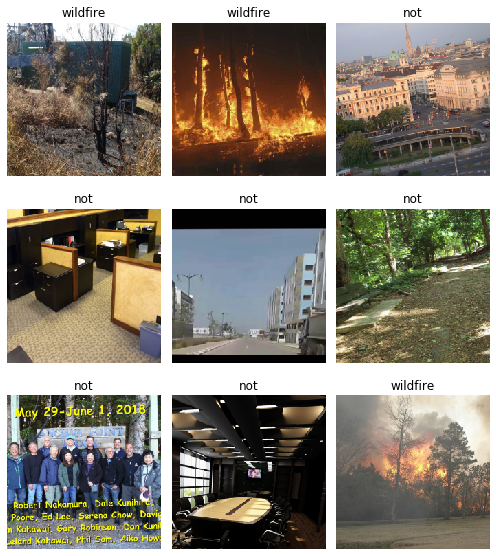

In [36]:
data.show_batch(rows=3, figsize=(7,8))

In [37]:
data.classes, data.c, len(data.train_ds), len(data.valid_ds)

(['not', 'wildfire'], 2, 5387, 1346)

In [46]:
learn = cnn_learner(data, models.resnet34, metrics=error_rate)

In [47]:
lr_find(learn)
learn.recorder.plot()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


OSError: Caught OSError in DataLoader worker process 4.
Original Traceback (most recent call last):
  File "/home/jakub/anaconda3/lib/python3.7/site-packages/torch/utils/data/_utils/worker.py", line 178, in _worker_loop
    data = fetcher.fetch(index)
  File "/home/jakub/anaconda3/lib/python3.7/site-packages/torch/utils/data/_utils/fetch.py", line 44, in fetch
    data = [self.dataset[idx] for idx in possibly_batched_index]
  File "/home/jakub/anaconda3/lib/python3.7/site-packages/torch/utils/data/_utils/fetch.py", line 44, in <listcomp>
    data = [self.dataset[idx] for idx in possibly_batched_index]
  File "/home/jakub/anaconda3/lib/python3.7/site-packages/fastai/data_block.py", line 651, in __getitem__
    if self.item is None: x,y = self.x[idxs],self.y[idxs]
  File "/home/jakub/anaconda3/lib/python3.7/site-packages/fastai/data_block.py", line 120, in __getitem__
    if isinstance(idxs, Integral): return self.get(idxs)
  File "/home/jakub/anaconda3/lib/python3.7/site-packages/fastai/vision/data.py", line 271, in get
    res = self.open(fn)
  File "/home/jakub/anaconda3/lib/python3.7/site-packages/fastai/vision/data.py", line 267, in open
    return open_image(fn, convert_mode=self.convert_mode, after_open=self.after_open)
  File "/home/jakub/anaconda3/lib/python3.7/site-packages/fastai/vision/image.py", line 398, in open_image
    x = PIL.Image.open(fn).convert(convert_mode)
  File "/home/jakub/anaconda3/lib/python3.7/site-packages/PIL/Image.py", line 2818, in open
    raise IOError("cannot identify image file %r" % (filename if filename else fp))
OSError: cannot identify image file '/home/jakub/fire_ml/downloads/wildfire/221.jpg'


In [44]:
os.remove("downloads/not/1049.jpg")

In [ ]:
lr = 1e-2

In [ ]:
learn.fit_one_cycle(4, slice(lr))